#Transfer Learning
This is a simple implementation of transfer learning, an image classifier was trained on a chosen dataset using a large, previously trained network.

## The dataset
The dataset used was [cats_vs_dogs dataset](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs).
## The model
The model used is MobileNet V2.

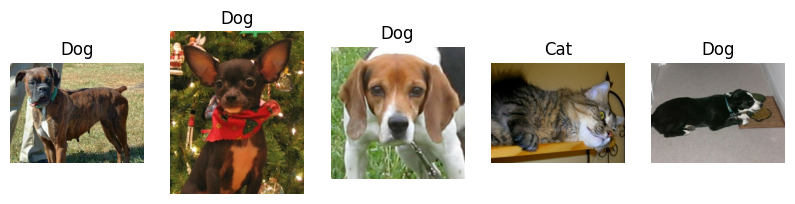

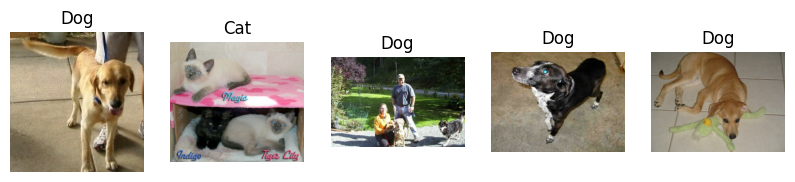

Epoch 1/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.5707 - loss: 0.7113 - val_accuracy: 0.6642 - val_loss: 0.5792
Epoch 2/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.6824 - loss: 0.5651 - val_accuracy: 0.7102 - val_loss: 0.5261
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 554s 2s/step - accuracy: 0.7251 - loss: 0.5215 - val_accuracy: 0.7341 - val_loss: 0.4997
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.7447 - loss: 0.4984 - val_accuracy: 0.7466 - val_loss: 0.4829
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.7559 - loss: 0.4831 - val_accuracy: 0.7599 - val_loss: 0.4710
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 551s 2s/step - accuracy: 0.7619 - loss: 0.4720 - val_accuracy: 0.7666 - val_loss: 0.4620
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.7688 - loss: 0.4635 - val_accuracy: 0.7732 - val_loss: 0.4549
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 580s 2s/step - accuracy: 0.7729 - loss: 0.4565 - val_accu

In [19]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load the cats_vs_dogs dataset
dataset, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split=['train[:80%]', 'train[80%:]'])


#Rename the splits to 'train' and 'test' for clarity
train_dataset = dataset[0]
test_dataset = dataset[1]


# Function to display images
def display_images(dataset, num_images=5):
  plt.figure(figsize=(10, 10))
  for i, (image, label) in enumerate(dataset.take(num_images)):
    plt.subplot(1, num_images, i+1)
    plt.imshow(image)
    plt.title("Cat" if label == 0 else "Dog")
    plt.axis('off')
  plt.show()


# Display some images from the training dataset
display_images(train_dataset)

# Display some images from the testing dataset
display_images(test_dataset)

#Transfer-learning implementation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

IMG_SIZE = 160
BATCH_SIZE = 64
BUFFER_SIZE = tf.data.AUTOTUNE

# Resize and rescale the images
def preprocess(image, label):
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) #Rescale the pixel values to [0,1]
  return image, label

# Apply preprocessing and batching to the datasets
train_dataset = train_dataset.map(preprocess).cache().batch(BATCH_SIZE).prefetch(buffer_size=BUFFER_SIZE)
test_dataset = test_dataset.map(preprocess).cache().batch(BATCH_SIZE).prefetch(buffer_size=BUFFER_SIZE)

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False # Freeze the convolutional base


# Add a classification head
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


# Train the model
initial_epochs = 10
history = model.fit(train_dataset.unbatch().batch(BATCH_SIZE),
                    epochs=initial_epochs,
                    validation_data=test_dataset.unbatch().batch(BATCH_SIZE))

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset.unbatch().batch(BATCH_SIZE),
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=test_dataset.unbatch().batch(BATCH_SIZE))

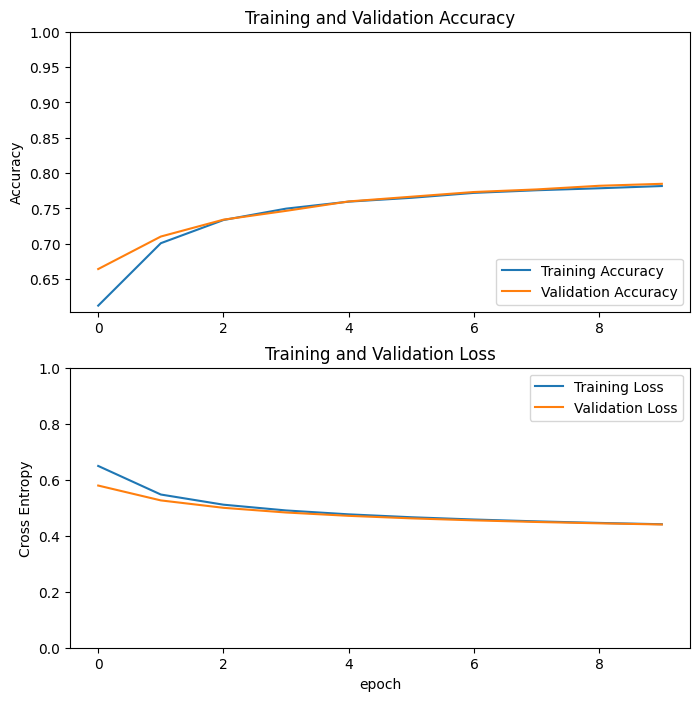

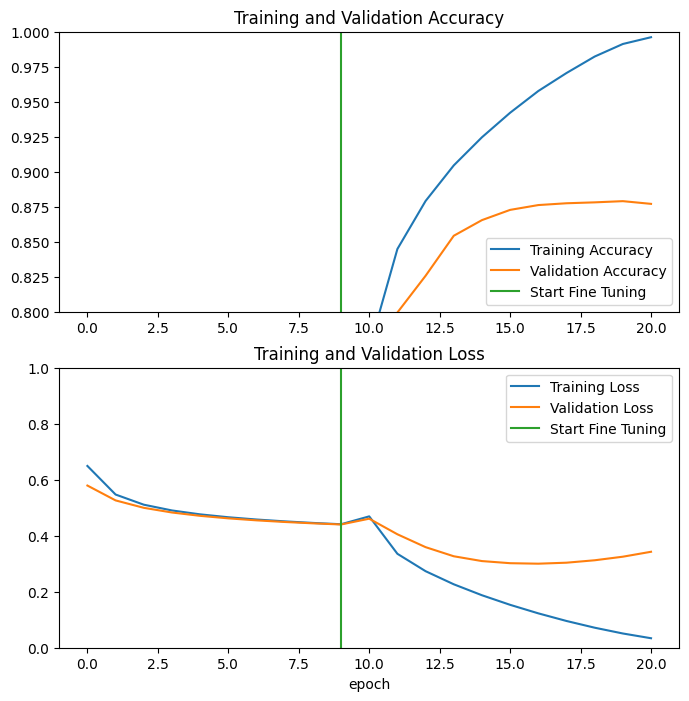

In [20]:
# Model evaluation
from IPython import get_ipython
from IPython.display import display

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a new figure and axes
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot on the first subplot
axs[0].plot(acc, label='Training Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy')
axs[0].legend(loc='lower right')
axs[0].set_ylabel('Accuracy')
axs[0].set_ylim([min(axs[0].get_ylim()), 1])
axs[0].set_title('Training and Validation Accuracy')

# Plot on the second subplot
axs[1].plot(loss, label='Training Loss')
axs[1].plot(val_loss, label='Validation Loss')
axs[1].legend(loc='upper right')
axs[1].set_ylabel('Cross Entropy')
axs[1].set_ylim([0, 1.0])
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('epoch')

plt.show()


acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

# Create a new figure and axes
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Plot on the first subplot
axs[0].plot(acc, label='Training Accuracy')
axs[0].plot(val_acc, label='Validation Accuracy')
axs[0].set_ylim([0.8, 1])
axs[0].plot([initial_epochs-1, initial_epochs-1],
          axs[0].get_ylim(), label='Start Fine Tuning')
axs[0].legend(loc='lower right')
axs[0].set_title('Training and Validation Accuracy')

# Plot on the second subplot
axs[1].plot(loss, label='Training Loss')
axs[1].plot(val_loss, label='Validation Loss')
axs[1].set_ylim([0, 1.0])
axs[1].plot([initial_epochs-1, initial_epochs-1],
          axs[1].get_ylim(), label='Start Fine Tuning')
axs[1].legend(loc='upper right')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('epoch')

plt.show()